In [30]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB

# Caricamento dei dati
df = pd.read_csv('data.csv')
t = 4500
W_values = [100, 200, 300, 400, 500]

# Liste per salvare i risultati
varianza_prima_ottimizzazione = []
valore_atteso_prima_ottimizzazione = []
varianza_seconda_ottimizzazione = []
valore_atteso_seconda_ottimizzazione = []
varianza_nuova_finestra = []
valore_atteso_nuova_finestra = []

# Funzione per eseguire le ottimizzazioni e stampare i risultati
def optimize_and_save_results(W):
    # Filtraggio dei dati per la finestra temporale
    window_data = df[(df['SampleTime'] >= t - W) & (df['SampleTime'] <= t)]

    # Pivot table per avere un formato adatto all'ottimizzazione
    pivot_data = window_data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)

    # Calcolo della penalizzazione basata sul numero di valori nulli originali
    null_counts = window_data.pivot(index='SampleTime', columns='SensorID', values='Value').isna().sum()
    penalty = null_counts / null_counts.max()  # Normalizzare la penalizzazione tra 0 e 1

    # Filtrare le colonne con tutti valori nulli
    pivot_data = pivot_data.dropna(axis=1, how='all')

    # Calcolo di media e varianza
    mean_vector = pivot_data.mean(axis=0, skipna=True).values
    cov_matrix = pivot_data.cov().values

    # Creare un dizionario per la penalizzazione con i nuovi indici
    penalty_dict = penalty[pivot_data.columns].to_dict()

    # Definizione dei parametri
    n = len(mean_vector)
    B = 10
    delta = 0.001 # Soglia minima per alpha

    # Numero di thread da utilizzare
    num_threads = 8
    time_limit = 300
    best_bd_stop_time = 300  # Tempo in secondi per fermare se BestBd non viene aggiornato

    # Creazione del modello per la prima ottimizzazione
    model1 = Model()

    # Impostazione del numero di thread e del limite di tempo
    model1.setParam('Threads', num_threads)
    model1.setParam('BestBdStop', best_bd_stop_time)

    # Aggiunta delle variabili
    alpha1 = model1.addVars(n, lb=0, ub=1, name="alpha1")
    b1 = model1.addVars(n, vtype=GRB.BINARY, name="b1")

    # Funzione obiettivo: minimizzare la varianza di Y con penalizzazione
    var_Y1 = sum(alpha1[i] * alpha1[j] * cov_matrix[i, j] for i in range(n) for j in range(n))
    penalized_var_Y1 = var_Y1 + sum(penalty_dict[pivot_data.columns[i]] * alpha1[i] for i in range(n))  # Aggiungere la penalizzazione
    model1.setObjective(penalized_var_Y1, GRB.MINIMIZE)

    # Vincoli
    model1.addConstr(sum(alpha1[i] for i in range(n)) == 1, "sum_alpha1")
    model1.addConstr(sum(b1[i] for i in range(n)) <= B, "sum_b1")
    for i in range(n):
        model1.addConstr(alpha1[i] <= b1[i], f"alpha1_b1_{i}")
        model1.addConstr(alpha1[i] >= delta * b1[i], f"alpha1_min_{i}")  # Nuovo vincolo per la soglia minima di alpha

    # Risoluzione del modello
    model1.optimize()

    # Estrazione dei risultati della prima ottimizzazione
    alpha_values1 = model1.getAttr('x', alpha1)
    b_values1 = model1.getAttr('x', b1)
    selected_sensors1 = [(pivot_data.columns[i], alpha_values1[i]) for i in range(n) if alpha_values1[i] > 0]

    # Calcolo della varianza minima ottenuta
    varianza_minima = sum(alpha_values1[i] * alpha_values1[j] * cov_matrix[i, j] for i in range(n) for j in range(n))

    # Calcolo del valore atteso dopo la prima ottimizzazione
    expected_value1 = sum(alpha_values1[i] * mean_vector[i] for i in range(n))

    # Salvataggio dei risultati della prima ottimizzazione
    varianza_prima_ottimizzazione.append(varianza_minima)
    valore_atteso_prima_ottimizzazione.append(expected_value1)

    # Stampa dei risultati della prima ottimizzazione
    print(f"Risultati Prima Ottimizzazione per W = {W}:")
    print("I 10 alpha diversi da 0 con i relativi SensorID:")
    for i, val in sorted(selected_sensors1, key=lambda x: x[1], reverse=True)[:10]:
        print(f"SensorID: {i}, alpha: {val}")
    alpha_sum1 = sum(val for _, val in selected_sensors1)
    print(f"Somma degli alpha diversi da 0: {alpha_sum1}")
    print(f"Varianza: {varianza_minima}")
    print(f"Valore atteso: {expected_value1}")

    # Creazione del modello per la seconda ottimizzazione
    model2 = Model()

    # Impostazione del numero di thread e del limite di tempo
    model2.setParam('Threads', num_threads)
    model2.setParam('TimeLimit', time_limit)

    # Aggiunta delle variabili
    alpha2 = model2.addVars(n, lb=0, ub=1, name="alpha2")
    b2 = model2.addVars(n, vtype=GRB.BINARY, name="b2")

    # Funzione obiettivo: massimizzare il valore atteso di Y con penalizzazione
    expected_Y = sum(alpha2[i] * mean_vector[i] for i in range(n))
    penalized_expected_Y = expected_Y - sum(penalty_dict[pivot_data.columns[i]] * alpha2[i] for i in range(n))  # Aggiungere la penalizzazione
    model2.setObjective(penalized_expected_Y, GRB.MAXIMIZE)

    # Vincoli
    model2.addConstr(sum(alpha2[i] for i in range(n)) == 1, "sum_alpha2")
    model2.addConstr(sum(b2[i] for i in range(n)) <= B, "sum_b2")
    for i in range(n):
        model2.addConstr(alpha2[i] <= b2[i], f"alpha2_b2_{i}")
        model2.addConstr(alpha2[i] >= delta * b2[i], f"alpha2_min_{i}")  # Nuovo vincolo per la soglia minima di alpha

    # Vincolo sulla varianza con tolleranza
    epsilon = 1e-6
    var_Y2 = sum(alpha2[i] * alpha2[j] * cov_matrix[i, j] for i in range(n) for j in range(n))
    model2.addConstr(var_Y2 <= varianza_minima - epsilon, "var_constraint")

    # Risoluzione del modello
    model2.optimize()

    # Estrazione dei risultati della seconda ottimizzazione
    alpha_values2 = model2.getAttr('x', alpha2)
    b_values2 = model2.getAttr('x', b2)
    selected_sensors2 = [(pivot_data.columns[i], alpha_values2[i]) for i in range(n) if alpha_values2[i] > 0]

    # Calcolo del valore atteso e della varianza ottenuti
    expected_value2 = sum(alpha_values2[i] * mean_vector[i] for i in range(n))
    varianza_seconda_ottimizzazione_value = sum(alpha_values2[i] * alpha_values2[j] * cov_matrix[i, j] for i in range(n) for j in range(n))

    # Verifica del vincolo di varianza
    if varianza_seconda_ottimizzazione_value > varianza_minima:
        print("Errore: la varianza dopo la seconda ottimizzazione è maggiore della varianza minima!")
    else:
        print("Il vincolo di varianza è rispettato.")

    # Salvataggio dei risultati della seconda ottimizzazione
    varianza_seconda_ottimizzazione.append(varianza_seconda_ottimizzazione_value)
    valore_atteso_seconda_ottimizzazione.append(expected_value2)

    # Stampa dei risultati della seconda ottimizzazione
    print(f"Risultati Seconda Ottimizzazione per W = {W}:")
    print("I 10 alpha diversi da 0 con i relativi SensorID:")
    for i, val in sorted(selected_sensors2, key=lambda x: x[1], reverse=True)[:10]:
        print(f"SensorID: {i}, alpha: {val}")
    alpha_sum2 = sum(val for _, val in selected_sensors2)
    print(f"Somma degli alpha diversi da 0: {alpha_sum2}")
    print(f"Varianza: {varianza_seconda_ottimizzazione_value}")
    print(f"Valore atteso: {expected_value2}")

    W_nuova = 600

    # Filtraggio dei dati per la finestra temporale da t a t + W_nuova
    new_window_data = df[(df['SampleTime'] >= t) & (df['SampleTime'] <= t + W_nuova)]

    # Pivot table per avere un formato adatto al calcolo
    new_pivot_data = new_window_data.pivot(index='SampleTime', columns='SensorID', values='Value').fillna(0)

    # Calcolo di media e varianza per la nuova finestra temporale
    new_mean_vector = new_pivot_data.mean(axis=0, skipna=True).values
    new_cov_matrix = new_pivot_data.cov().values

    # Calcolo del valore atteso e della varianza utilizzando gli alpha dalla seconda ottimizzazione
    expected_value_new = sum(alpha_values2[I] * new_mean_vector[I] for I in range(n))
    varianza_new = sum(alpha_values2[I] * alpha_values2[j] * new_cov_matrix[I, j] for I in range(n) for j in range(n))

    # Salvataggio dei risultati per la nuova finestra
    varianza_nuova_finestra.append(varianza_new)
    valore_atteso_nuova_finestra.append(expected_value_new)

    # Stampa dei risultati per la nuova finestra temporale
    print(f"Varianza per la nuova finestra temporale: {varianza_new}")
    print(f"Valore atteso per la nuova finestra temporale: {expected_value_new}")

# Esecuzione del ciclo per ogni valore di W
for W in W_values:
    print(f"Esecuzione per W = {W}")
    optimize_and_save_results(W)

Esecuzione per W = 100
Set parameter Threads to value 8
Set parameter BestBdStop to value 300
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1706 rows, 1704 columns and 5112 nonzeros
Model fingerprint: 0xf7f06abc
Model has 363378 quadratic objective terms
Variable types: 852 continuous, 852 integer (852 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-01, 1e+00]
  QObjective range [2e-10, 8e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 0.0001810
Presolve time: 0.10s
Presolved: 1706 rows, 1704 columns, 5112 nonzeros
Presolved model has 363378 quadratic objective terms
Variable types: 852 continuous, 852 integer (852 binary)

Root relaxation: objective 9.563171e-07, 422 iterations, 0.04 seconds (0.06 work units)

    Nodes    |    C

In [20]:
# Caricamento dei dati
df = pd.read_csv('data.csv')  # Assumendo che il file sia un CSV, sostituisci con il tuo file
t = 4500
W_values = [100, 200, 300, 400, 500]

# Liste per salvare i risultati
varianza_senza_ottimizzazione = []
valore_atteso_senza_ottimizzazione = []

# Funzione per calcolare varianza e valore atteso senza ottimizzazione
def calculate_without_optimization(W):
    # Filtraggio dei dati per la finestra temporale da t a t + W
    new_window_data = df[(df['SampleTime'] >= t - W) & (df['SampleTime'] <= t)]

    # Pivot table per avere un formato adatto al calcolo
    new_pivot_data = new_window_data.pivot(index='SampleTime', columns='SensorID', values='Value')

    # Calcolo di media e varianza per la nuova finestra temporale
    new_mean_vector = new_pivot_data.mean(axis=0, skipna=True).values
    new_cov_matrix = new_pivot_data.cov().values

    # Calcolo del valore atteso e della varianza senza applicare l'ottimizzazione degli alpha
    mean_vector_no_opt = np.nanmean(new_mean_vector)  # Media dei valori dei sensori
    varianza_no_opt = np.nanmean(new_cov_matrix)  # Media della matrice di covarianza

    # Salvataggio dei risultati per la nuova finestra temporale senza ottimizzazione
    varianza_senza_ottimizzazione.append(varianza_no_opt)
    valore_atteso_senza_ottimizzazione.append(mean_vector_no_opt)

    # Stampa dei risultati per la nuova finestra temporale senza ottimizzazione
    print(f"Varianza per la finestra temporale (senza ottimizzazione degli alpha) per W = {W}: {varianza_no_opt}")
    print(f"Valore atteso per la finestra temporale (senza ottimizzazione degli alpha) per W = {W}: {mean_vector_no_opt}")

# Esecuzione del ciclo per ogni valore di W
for W in W_values:
    print(f"Esecuzione per W = {W}")
    calculate_without_optimization(W)

# Risultati finali
print("Risultati finali senza ottimizzazione:")
print(f"Varianza Senza Ottimizzazione: {varianza_senza_ottimizzazione}")
print(f"Valore Atteso Senza Ottimizzazione: {valore_atteso_senza_ottimizzazione}")

Esecuzione per W = 100
Varianza per la finestra temporale (senza ottimizzazione degli alpha) per W = 100: 2.313787298189183e-05
Valore atteso per la finestra temporale (senza ottimizzazione degli alpha) per W = 100: 0.0005597914732470289
Esecuzione per W = 200
Varianza per la finestra temporale (senza ottimizzazione degli alpha) per W = 200: 2.3173489396610615e-05
Valore atteso per la finestra temporale (senza ottimizzazione degli alpha) per W = 200: 0.0007373613783428187
Esecuzione per W = 300
Varianza per la finestra temporale (senza ottimizzazione degli alpha) per W = 300: 2.7196406692723093e-05
Valore atteso per la finestra temporale (senza ottimizzazione degli alpha) per W = 300: 0.0005325246357093799
Esecuzione per W = 400
Varianza per la finestra temporale (senza ottimizzazione degli alpha) per W = 400: 4.2364148922205306e-05
Valore atteso per la finestra temporale (senza ottimizzazione degli alpha) per W = 400: 0.0008602476147573733
Esecuzione per W = 500
Varianza per la finest

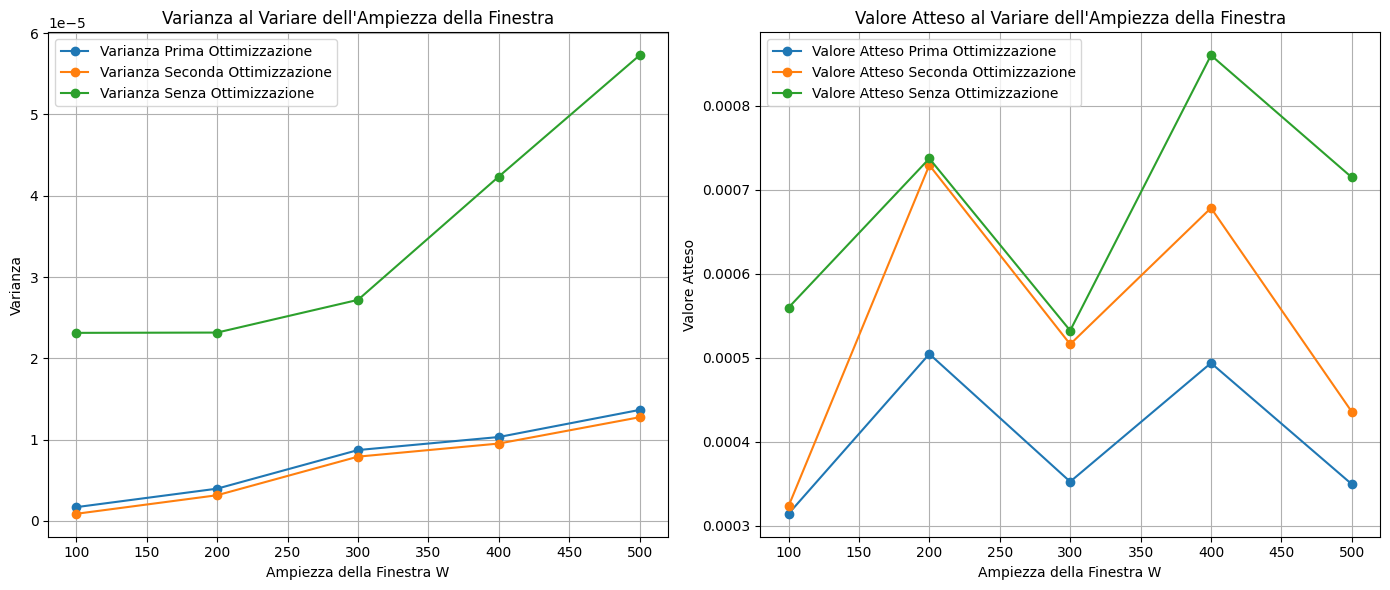

In [28]:
import matplotlib.pyplot as plt

# Offset per evitare sovrapposizioni complete
offset = 4e-7

# Applicazione degli offset alle varianze
varianza_prima_offset = [v + offset for v in varianza_prima_ottimizzazione]
varianza_seconda_offset = [v - offset for v in varianza_seconda_ottimizzazione]

# Grafico della varianza
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(W_values, varianza_prima_offset, label='Varianza Prima Ottimizzazione', marker='o')
plt.plot(W_values, varianza_seconda_offset, label='Varianza Seconda Ottimizzazione', marker='o')
plt.plot(W_values, varianza_senza_ottimizzazione, label='Varianza Senza Ottimizzazione', marker='o')
plt.xlabel('Ampiezza della Finestra W')
plt.ylabel('Varianza')
plt.title('Varianza al Variare dell\'Ampiezza della Finestra')
plt.legend()
plt.grid(True)

# Grafico del valore atteso
plt.subplot(1, 2, 2)
plt.plot(W_values, valore_atteso_prima_ottimizzazione, label='Valore Atteso Prima Ottimizzazione', marker='o')
plt.plot(W_values, valore_atteso_seconda_ottimizzazione, label='Valore Atteso Seconda Ottimizzazione', marker='o')
plt.plot(W_values, valore_atteso_senza_ottimizzazione, label='Valore Atteso Senza Ottimizzazione', marker='o')
plt.xlabel('Ampiezza della Finestra W')
plt.ylabel('Valore Atteso')
plt.title('Valore Atteso al Variare dell\'Ampiezza della Finestra')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Caricamento dei dati
df = pd.read_csv('data.csv')  # Assumendo che il file sia un CSV, sostituisci con il tuo file
t = 4500
W_values = [100, 200, 300, 400, 500]

# Liste per salvare i risultati
nuova_varianza_senza_ottimizzazione = []
nuovo_valore_atteso_senza_ottimizzazione = []

# Funzione per calcolare varianza e valore atteso senza ottimizzazione
def calculate_without_optimization(W):
    # Filtraggio dei dati per la finestra temporale da t a t + W
    new_window_data = df[(df['SampleTime'] >= t) & (df['SampleTime'] <= t + W)]

    # Pivot table per avere un formato adatto al calcolo
    new_pivot_data = new_window_data.pivot(index='SampleTime', columns='SensorID', values='Value')

    # Calcolo di media e varianza per la nuova finestra temporale
    new_mean_vector = new_pivot_data.mean(axis=0, skipna=True).values
    new_cov_matrix = new_pivot_data.cov().values

    # Calcolo del valore atteso e della varianza senza applicare l'ottimizzazione degli alpha
    mean_vector_no_opt = np.nanmean(new_mean_vector)  # Media dei valori dei sensori
    varianza_no_opt = np.nanmean(new_cov_matrix)  # Media della matrice di covarianza

    # Salvataggio dei risultati per la nuova finestra temporale senza ottimizzazione
    nuova_varianza_senza_ottimizzazione.append(varianza_no_opt)
    nuovo_valore_atteso_senza_ottimizzazione.append(mean_vector_no_opt)

    # Stampa dei risultati per la nuova finestra temporale senza ottimizzazione
    print(f"Varianza per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = {W}: {varianza_no_opt}")
    print(f"Valore atteso per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = {W}: {mean_vector_no_opt}")

# Esecuzione del ciclo per ogni valore di W
for W in W_values:
    print(f"Esecuzione per W = {W}")
    calculate_without_optimization(W)

# Risultati finali
print("Risultati finali senza ottimizzazione:")
print(f"Varianza Senza Ottimizzazione: {nuova_varianza_senza_ottimizzazione}")
print(f"Valore Atteso Senza Ottimizzazione: {nuovo_valore_atteso_senza_ottimizzazione}")

Esecuzione per W = 100
Varianza per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 100: 3.3366351554568854e-05
Valore atteso per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 100: 0.0009611665998371708
Esecuzione per W = 200
Varianza per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 200: 3.901404054046928e-05
Valore atteso per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 200: 0.0008298764349487912
Esecuzione per W = 300
Varianza per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 300: 5.1532046749758125e-05
Valore atteso per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 300: 0.0005549776671154084
Esecuzione per W = 400
Varianza per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 400: 5.6038279003237906e-05
Valore atteso per la nuova finestra temporale (senza ottimizzazione degli alpha) per W = 400: 0.00071587622567482

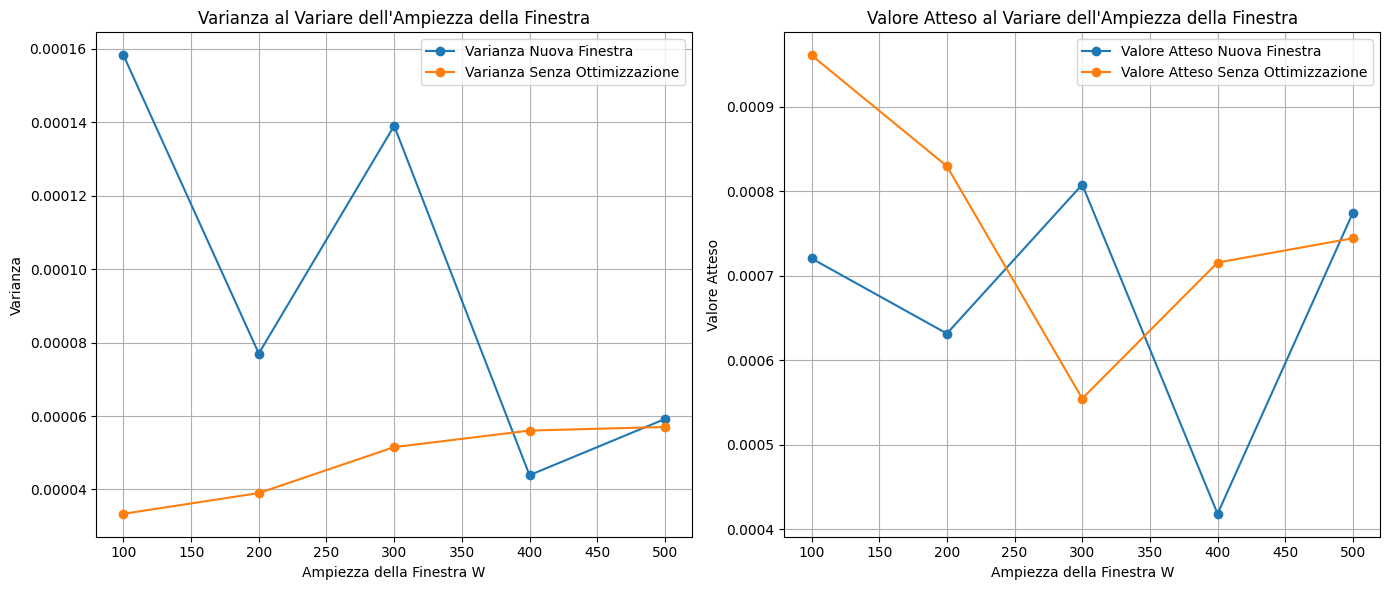

In [23]:
# Grafico della varianza
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(W_values, varianza_nuova_finestra, label='Varianza Nuova Finestra', marker='o')
plt.plot(W_values, nuova_varianza_senza_ottimizzazione, label='Varianza Senza Ottimizzazione', marker='o')
plt.xlabel('Ampiezza della Finestra W')
plt.ylabel('Varianza')
plt.title('Varianza al Variare dell\'Ampiezza della Finestra')
plt.legend()
plt.grid(True)

# Grafico del valore atteso
plt.subplot(1, 2, 2)
plt.plot(W_values, valore_atteso_nuova_finestra, label='Valore Atteso Nuova Finestra', marker='o')
plt.plot(W_values, nuovo_valore_atteso_senza_ottimizzazione, label='Valore Atteso Senza Ottimizzazione', marker='o')
plt.xlabel('Ampiezza della Finestra W')
plt.ylabel('Valore Atteso')
plt.title('Valore Atteso al Variare dell\'Ampiezza della Finestra')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()